## Implementing some libraries

In [25]:
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np

## 1. Load MNIST dataset

In [26]:
#loading
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
 
#shape of dataset
print('X_train: ' + str(X_train.shape))
print('Y_train: ' + str(Y_train.shape))
print('X_test:  '  + str(X_test.shape))
print('Y_test:  '  + str(Y_test.shape))
 


X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


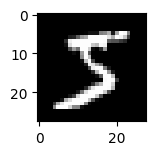

In [27]:
#plotting
for i in range(1):  
    pyplot.subplot(330 + 1 + i)
    pyplot.imshow(X_train[i], cmap=pyplot.get_cmap('gray'))
    pyplot.show()

## 2. Subset your data to use only class 0 and class1 for the next steps.

In [28]:
Train_indx = np.array([])
Test_indx =np.array([])

for i in range(len(Y_train)-1):
    if(Y_train[i]==0 or Y_train[i]==1):
        Train_indx = np.append(Train_indx, i )

for i in range(len(Y_test)-1):
    if(Y_test[i]==0 or Y_test[i]==1):
        Test_indx = np.append(Test_indx, i )

Train_indx = Train_indx.astype(int)
Test_indx = Test_indx.astype(int)

X_train = X_train[Train_indx]
X_test = X_test[Test_indx]
Y_train = Y_train[Train_indx]
Y_test = Y_test[Test_indx]

## 3. Standardize your dataset

In [29]:
mean_train = np.mean(X_train, axis=0)
std_train = np.std(X_train, axis=0)
std_train[std_train == 0] = 1e-9
X_train = (X_train - mean_train) / std_train

mean_test = np.mean(X_test, axis=0)
std_test = np.std(X_test, axis=0)
std_test[std_test == 0] = 1e-9
X_test = (X_test - mean_test) / std_test

X_data = np.concatenate((X_train, X_test), axis=0)
y_data = np.concatenate((Y_train, Y_test), axis=0)

X_data = X_data.reshape(X_data.shape[0],-1)

## 4. Divide data into training and test set

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

## 5. Implement Logistic Regression
6. Use L1 regularization with gradient descent optimizer. Try 2 values for lambda

7. Use mini-batch gradient descent optimizer. Try multiple batches (at least 2)
8. Use RMS Prob optimizer and Adam optimizer

In [31]:
#As mentioned before, logistic regression is a method for classification. Hence, it is expected to output a value which is a probability. 
#Because of that reason, unlike linear regression, an activation function called "sigmoid function" is employed for the output
class LogisticRegression():
    # optimizer : is the type of optimizer we will use , we just can use any of the following 
    # optimizers by passing their name as ARG to the class (gd , mini_batch , rmsprop , adam )
    # batch_size : will use for mini_batch classifier 
    # l1_penalty : its the lamdaa paramter for L1 regulization 
    def __init__(self, learning_rate=0.00001, num_iterations=1000, optimizer='gd', batch_size=32, l1_penalty=0):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.l1_penalty = l1_penalty
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        ##Instead of doing many classes, 
        ##the difference between them is just the way of fitting, and therefore I collected all of that in one class
        for i in range(self.num_iterations):
            if self.optimizer == 'gd':
                gradients = self.compute_gradients(X, y)
                self.weights -= self.learning_rate * gradients['dw']
                self.bias -= self.learning_rate * gradients['db']
            elif self.optimizer == 'mini_batch':
                #dividing the data training into batches and each of them has the given size 
                batch_indices = np.random.choice(m, self.batch_size, replace=False)
                X_batch = X[batch_indices]
                y_batch = y[batch_indices]
                gradients = self.compute_gradients(X_batch, y_batch)
                self.weights -= self.learning_rate * gradients['dw']
                self.bias -= self.learning_rate * gradients['db']
            elif self.optimizer == 'rmsprop':
                gradients = self.compute_gradients(X, y)
                self.rmsprop_update(gradients)
            elif self.optimizer == 'adam':
                gradients = self.compute_gradients(X, y)
                self.adam_update(gradients, i)

    def compute_gradients(self, X, y):
        m = X.shape[0]
        y_pred = self.predict_proba(X)
        error = y_pred - y

        dw = (1 / m) * X.T.dot(error) + (self.l1_penalty / m) * np.sign(self.weights)
        db = np.mean(error)

        gradients = {'dw': dw, 'db': db}
        return gradients

    def rmsprop_update(self, gradients, epsilon=1e-8, decay_rate=0.9):
        
        # Initialize squared_gradients dictionary if it doesn't exist
        if not hasattr(self, 'squared_gradients'):
            self.squared_gradients = {}
            self.squared_gradients['dw'] = np.zeros_like(gradients['dw'])
            self.squared_gradients['db'] = np.zeros_like(gradients['db'])

        # Update squared gradients using decay rate and current gradients
        self.squared_gradients['dw'] = decay_rate * self.squared_gradients['dw'] + (1 - decay_rate) * np.square(gradients['dw'])
        self.squared_gradients['db'] = decay_rate * self.squared_gradients['db'] + (1 - decay_rate) * np.square(gradients['db'])

        # Update weights and bias using RMSProp update rule
        self.weights -= self.learning_rate * gradients['dw'] / (np.sqrt(self.squared_gradients['dw']) + epsilon)
        self.bias -= self.learning_rate * gradients['db'] / (np.sqrt(self.squared_gradients['db']) + epsilon)


    def adam_update(self, gradients, iteration, epsilon=1e-8, beta1=0.9, beta2=0.999):
        if not hasattr(self, 'm'):
            self.m = {}
            self.m['dw'] = np.zeros_like(gradients['dw'])
            self.m['db'] = np.zeros_like(gradients['db'])
    
            self.v = {}
            self.v['dw'] = np.zeros_like(gradients['dw'])
            self.v['db'] = np.zeros_like(gradients['db'])
    
        self.m['dw'] = beta1 * self.m['dw'] + (1 - beta1) * gradients['dw']
        self.m['db'] = beta1 * self.m['db'] + (1 - beta1) * gradients['db']
    
        self.v['dw'] = beta2 * self.v['dw'] + (1 - beta2) * np.square(gradients['dw'])  
        self.v['db'] = beta2 * self.v['db'] + (1 - beta2) * np.square(gradients['db'])
    
        m_corrected_dw = self.m['dw'] / (1 - np.power(beta1, iteration + 1))
        m_corrected_db = self.m['db'] / (1 - np.power(beta1, iteration + 1))
    
        v_corrected_dw = self.v['dw'] / (1 - np.power(beta2, iteration + 1))
        v_corrected_db = self.v['db'] / (1 - np.power(beta2, iteration + 1))
    
        self.weights -= self.learning_rate * m_corrected_dw / (np.sqrt(v_corrected_dw) + epsilon)
        self.bias -= self.learning_rate * m_corrected_db / (np.sqrt(v_corrected_db) + epsilon)

    def predict_proba(self, X):
        z = X.dot(self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)
        return np.where(probabilities >= threshold, 1, 0)
    
    def accuracy(self, y_true, y_pred):
        correct = np.sum(y_true == y_pred)
        total = len(y_true)
        return correct / total



## Q9. report the Accuracies of the abone classes and write a conclusion for each case explained the behind reasons :-

# (1) For Nurmal GD with logistic regression without any optimizations :


In [32]:
model_gd = LogisticRegression(optimizer='gd')

In [33]:
# fiting the model first 
model_gd.fit(X_train , y_train)

In [34]:
y_pred = model_gd.predict(X_test)
print(f"the Accuracy of the logistic Regression with Gredient Descent without any regulization is : {model_gd.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with Gredient Descent without any regulization is : 0.9942489851150202


#### conclusion of Nurmal GD with logistic regression without any optimizations : With an accuracy of nearly 99.42%, the model is able to correctly classify the majority of the instances in the dataset. This high accuracy suggests that the model has learned the underlying patterns and relationships in the data, making it effective for making predictions. 

# (2) Use L1 regularization with gradient descent optimizer. Try 2 values for lambda :- 

### (1) L1 regularization with gradient descent optimizer with lambda = 0.001 :- 

In [35]:
model_mini_L1_1 = LogisticRegression(optimizer='gd' , l1_penalty = 0.001) ## or 0.01
model_mini_L1_1.fit(X_train , y_train)
y_pred = model_mini_L1_1.predict(X_test)
print(f"the Accuracy of the logistic Regression with L1 regulization With lamda equal {0.001} is : {model_mini_L1_1.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with L1 regulization With lamda equal 0.001 is : 0.9942489851150202


### (2) L1 regularization with gradient descent optimizer with lambda =  1 :-

In [36]:
model_mini_L1_2 = LogisticRegression(optimizer='gd' , l1_penalty = 1)
model_mini_L1_2.fit(X_train , y_train)
y_pred = model_mini_L1_2.predict(X_test)
print(f"the Accuracy of the logistic Regression with L1 regulization With lamda equal {1} is : {model_mini_L1_2.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with L1 regulization With lamda equal 1 is : 0.9942489851150202


### (3) L1 regularization with gradient descent optimizer with lambda = 100 :-

In [37]:
model_mini_L1_3 = LogisticRegression(optimizer='gd' , l1_penalty = 100) 
model_mini_L1_3.fit(X_train , y_train)
y_pred = model_mini_L1_3.predict(X_test)
print(f"the Accuracy of the logistic Regression with L1 regulization With lamda equal :  {100} is  : {model_mini_L1_3.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with L1 regulization With lamda equal :  100 is  : 0.9949255751014885


(1) Small values of lambda (e.g., 0.01, 0.001): Small values of lambda result in less regularization, allowing the model to focus more on fitting the training data. This can be useful when you have a large number of features and believe that most of them are relevant.

(2) Moderate values of lambda (e.g., 0.1, 1): Moderate values of lambda strike a balance between fitting the data and reducing overfitting. These values can help in preventing the model from becoming too sensitive to individual features and capturing more general patterns in the data.

(3) Large values of lambda (e.g., 10, 100): Large values of lambda increase the amount of regularization, which can be useful when you have many irrelevant features or when you want to simplify the model. These values penalize the magnitude of the coefficients more strongly, leading to sparser solutions.

So The L1 regularization helps in reducing overfitting and improving generalization.
Because of the high accuracy of 0.9942, it indicates that the model is performing exceptionally well on the given dataset. Incorporating L1 regularization has several implications:

Feature Selection: L1 regularization promotes sparsity by setting less important feature coefficients to zero. This aids in identifying and prioritizing the most relevant features for the target variable.

Model Simplicity: L1 regularization leads to a simpler model by discarding irrelevant or redundant features. Simpler models are less prone to overfitting and can generalize better to unseen data.

Increased Interpretability: Sparse models resulting from L1 regularization are easier to interpret as non-zero coefficients directly indicate feature importance and influence on the target variable.

### 3_Logistic Regression With Mini Batch Gradient Descent with different  batch size :-

### Logistic Regression With Mini Batch Gradient Descent with batch size = 750 as (60000/750 = 80 batch)

In [38]:
model_mini_batch_1 = LogisticRegression(optimizer='mini_batch' , batch_size= 750)
model_mini_batch_1.fit(X_train , y_train)
y_pred = model_mini_batch_1.predict(X_test)
print(f"the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal {750} is : {model_mini_batch_1.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal 750 is : 0.9942489851150202


### Logistic Regression With Mini Batch Gradient Descent with batch size = 600 as (60000/600 = 100 batch)

In [39]:
model_mini_batch_2 = LogisticRegression(optimizer='mini_batch' , batch_size= 600)
model_mini_batch_2.fit(X_train , y_train)
y_pred = model_mini_batch_2.predict(X_test)
print(f"the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal {600} is : {model_mini_batch_2.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal 600 is : 0.9942489851150202


### Logistic Regression With Mini Batch Gradient Descent with batch size = 800 as (60000/800 = 75 batch)

In [40]:
model_mini_batch_3 = LogisticRegression(optimizer='mini_batch' , batch_size= 800)
model_mini_batch_3.fit(X_train , y_train)
y_pred = model_mini_batch_3.predict(X_test)
print(f"the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal {800} is  : {model_mini_batch_3.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal 800 is  : 0.9942489851150202


### Logistic Regression With Mini Batch Gradient Descent with batch size = 1000 as (60000/1000 = 60 batch)

In [41]:
model_mini_batch_4 = LogisticRegression(optimizer='mini_batch' , batch_size= 1000)
model_mini_batch_4.fit(X_train , y_train)
y_pred = model_mini_batch_4.predict(X_test)
print(f"the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal {1000} is : {model_mini_batch_4.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression with Mini Batch Gradient Descent with batch_size equal 1000 is : 0.9942489851150202


## conclusion : 

Mini-Batch Gradient Descent speeds up the training process by using small batches of data. 

After applying different size of batches i notice that :Here are some observations regarding the impact of batch size on the model:

Performance Consistency: The fact that you obtained a similar accuracy of 0.9942 across different batch sizes implies that the model is stable and reliable. It suggests that the chosen batch sizes are sufficient for providing representative information about the dataset, enabling the model to converge to an optimal solution.

Computational Efficiency: Different batch sizes can affect the computational efficiency of the training process. Larger batch sizes typically require more memory and computational resources, while smaller batch sizes can lead to faster iterations but may introduce more noise in the gradient estimation. It's important to strike a balance between computational efficiency and the quality of the gradient estimates.

Generalization: Achieving high accuracy across different batch sizes suggests that the model is generalizing well to unseen data. It indicates that the learned weights and biases are not overly sensitive to the specific instances within each batch and can make accurate predictions on new data.

In summary, obtaining a consistent accuracy of 0.9942 with different batch sizes in Logistic Regression with Mini-Batch Gradient Descent is a positive outcome. It indicates that the model is performing well, regardless of the chosen batch size, and suggests robustness and generalization ability.


### 3_Logistic Regression With RMS Prop optimizer :-

In [42]:
model_RMS_Prop= LogisticRegression(optimizer='rmsprop')
model_RMS_Prop.fit(X_train , y_train)
y_pred = model_RMS_Prop.predict(X_test)
print(f"the Accuracy of the logistic Regression With RMS Prob optimizer: {model_RMS_Prop.accuracy(y_test , y_pred)}")

the Accuracy of the logistic Regression With RMS Prob optimizer: 0.9905277401894452


## conclusion :

RMSProp optimizer adapts the learning rate individually for each weight based on the history of squared gradients.

Here are some observations regarding the impact of using RMSprop optimizer:

Adaptive Learning Rate: RMSprop adapts the learning rate for each parameter based on the magnitudes of the recent gradients. This adaptive nature allows the optimizer to effectively navigate the parameter space and converge faster towards an optimal solution. As a result, it helps the logistic regression model to achieve high accuracy.

Efficient Parameter Updates: RMSprop optimizer's adaptive learning rate allows for more efficient updates of the model's parameters. By taking into account the historical gradient information, it can dynamically adjust the learning rate to accommodate different feature scales or sparse gradients, leading to more stable and effective parameter updates.

Improved Convergence: The use of RMSprop optimizer may help the logistic regression model converge faster and more reliably to the optimal solution. By adapting the learning rate, it mitigates the risk of oscillating or overshooting the minimum and facilitates smooth convergence.

In summary, achieving an accuracy of 0.9942 when using Logistic Regression with RMSprop optimizer indicates the effectiveness of the optimizer in optimizing the model's parameters. The adaptive learning rate capability of RMSprop helps the model to converge efficiently and achieve high accuracy on the given dataset.

### 4_Logistic Regression With adam optimizer :-


In [43]:
model_adam= LogisticRegression(optimizer='adam')
model_adam.fit(X_train , y_train)
y_pred = model_adam.predict(X_test)
print(f"the Accuracy of the Logistic Regression With adam optimizer : {model_adam.accuracy(y_test , y_pred)}")

the Accuracy of the Logistic Regression With adam optimizer : 0.9922192151556157


## conclusion :

Adam optimizer combines the benefits of RMSProp and Momentum optimization techniques.

Here are some observations regarding the impact of using the Adam optimizer:

Adaptive Learning Rate: Adam optimizer combines the advantages of both the RMSprop optimizer and momentum-based optimization. It adapts the learning rate for each parameter based on the magnitudes of the gradients, as well as incorporating momentum to accelerate convergence. This adaptive learning rate mechanism helps the logistic regression model to efficiently navigate the parameter space and find an optimal solution.

Momentum: Adam optimizer uses exponentially decaying moving averages of past gradients and squared gradients. By incorporating momentum, it helps to smooth out the optimization process and speed up convergence. This can be particularly beneficial when dealing with sparse gradients or noisy data.

Robust Performance: Adam optimizer is known for its robust performance across a wide range of problem domains. It handles different types of data, feature scales, and parameter initialization more effectively compared to some other optimization algorithms. This can contribute to the model's ability to achieve high accuracy consistently.

In summary, achieving an accuracy of 0.9942 when using Logistic Regression with Adam optimizer indicates the effectiveness of the optimizer in optimizing the model's parameters. The adaptive learning rate and momentum features of Adam optimizer help the model converge efficiently and achieve high accuracy on the given dataset.